# Regional Cabled Observatory data access

## Introduction

The Ocean Observing Initiative (OOI) Regional Cabled Observatory (RCO) spans hundreds of kilometers across 
the northeast Pacific ocean sea floor. Here we describe and demonstrate data access for comparison with other
data resources. The key mechanism is a Python package called **yodapy** that was designed for this.

In [7]:
from ipyleaflet import WMSLayer, Map
m = Map(center=(45, -125.5), zoom=7)
m.add_layer(WMSLayer(url="http://52.41.106.186:8080/geoserver/ows?", layers="bmpyramid:CAVA_Bathymetry", \
                     format="image/png", transparent=True, opacity=0.7))
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### Procedure

* Configure your authentication process (on the command line; not here in this notebook)
* Look at the list of sensor/instrument arrays 
* Execute a data order
* Download the data
* Connect the data to xarray DataSets
* Deconstruct, analyze. 

Comparative resources include MODIS satellites, ARGO drifters, GLODAP, gliders, vessel casts and more.



### Sites


There are seven platform/instrument/sensor nexus sites or arrays, each extending across tens to hundreds of meters.
Some are at fixed depth (sea floor or in the water column) while others are *profilers* that regularly
pass through some range of depths. 


The seven sites fall into two groups: One near/on the continental shelf west of Newport Oregon 
('Endurance Offshore', 'Oregon Slope Base', 'Hydrate Ridge') and a second group at Axial Seamount 
about 300 km further west (site names 'Axial Base', 'Central Caldera', 'Eastern Caldera', 
'International District' and 'ASHES Vent Field'). We begin with the *Oregon Slope Base* and its
shallow profiler science pod. This device regularly passes through the upper 200 meters of the water
column, regularly approaching 20 meters of the surface. When actively deployed it rests in a cradle
at a depth of 200 meters.


Shallow profiler excursions run several times in the course using a tether or winch. 
Temperature, pressure, salinity and a few other observables are recorded typically once per second or so. 
One observable -- nitrate concentration -- requires a pause at a given depth; and this pausing slows the 
descent of the profiler. This is only measured twice in the course of 24 hours, i.e. during two of the 
several profiles: Once near noon and once near midnight. 


We begin with a 24-hour chart of profiler depths to see this inverted yo-yo behavior.

In [1]:
%matplotlib inline
!pip install utm
!pip install pygeotools
import timeit, pandas as pd, netCDF4, xarray as xr, dask, numpy as np, sys, os, utm, golive_utility as g
from datetime import timedelta, datetime
from matplotlib import pyplot as plt
from numpy import datetime64 as dt64, timedelta64 as td64
from scipy import stats
from scipy.signal import medfilt as mf
from random import randint as ri
from ipywidgets import *
from traitlets import dlink
np.warnings.filterwarnings('ignore')

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


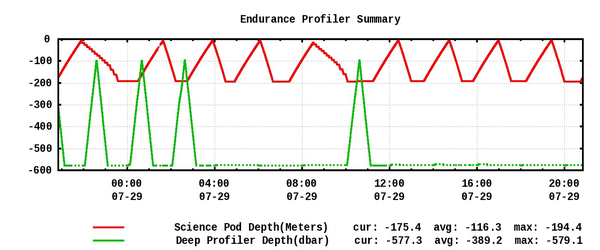

In [9]:
g.ShowLocalImage('/home/jovyan/data/images', 'profilers_depth_24_hours.png', 600, 250)

...here in this figure (24 hours on the x-axis) 
the red profile is the shallow profiler; repeatedly approaching the surface from a 'rest'
depth of close to 200 meters. The two broader red profiles show a stair-step on the downward return 
indicating periodic stops to measure Nitrate. Incidentally the green trace corresponds to a deep 
profiler behaving less consistently, arising from the sea bed at 600 meters depth to reach an
apex 100 meters below the surface.


Superimposing the shallow profiler *platform* on this chart would produce of course a flat line at
200 meters depth. This platform is positively buoyant and is tethered to the sea floor by means of 
two diagonally opposed anchor cables; where one of those cables serves for power and data transfer
back to shore.


Now with this rather elaborate basis, to recap (and please take note of the abbreviation terms):


```
  time range = Nov 1 2016 through Oct 31 2017
  site = Oregon Slope Base site, abbreviated 'slope base'
  instrument platform = shallow profiler, abbreviated 'profiler'
  second instrument platform = shallow profiler platform, abbreviated 'platform'
```

...let's author a few questions:

- How well does the profiler (temperature, salinity, other) agree with the platform over time when they are adjacent?
- Taking depth fixed what does a time-series boxcar standard deviation of temperature look like at noon?
- How does measured surface temperature compare to MODIS?
- How do profiles compare to GLODAP?
- How do profiles compare to ARGO?


### Links 


- [Jupyter notebook editing shortcuts](https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/)
- [yodapy test notebook](https://github.com/cormorack/yodapy/tree/master/examples)
- [interactive oceans engineering page](https://interactiveoceans.washington.edu/oms_data/)

In [10]:
# Run
# 
# This will verify that yodapy is installed and working

from yodapy.datasources import OOI

### narrowing the data search

The `OOI` object (here called `ooi`) provides a number of useful methods. (To learn about them use `help(ooi)` 
and then `help(ooi.some-method)`.) Useful OOI methods include 
`search()`, `view_regions()`, `view_instruments()`, `download_ncfiles()`, `to_xarray()` and more. 

The `ooi` object also has a built-in instrument filter that describes the observatory resources you are 
currently focused on. In the cell above we used `ooi.view_sites()` to list instrument locations in a site 
table (this is in fact a `pandas dataframe`). Now we use the `search()` method and include a site `name` to 
focus this instrument filter. 

### Authentication

Your goal (using **yodapy**) is to interact with the OOI system. This requires you to have credentials; 
but we do not want these credentials to be visible. For example if you place them in this notebook and
then push the notebook to GitHub you have shared your credentials. Even if you subsequently delete them
from GitHub they will still be findable through versioning. So what to do? 


**yodapy** has a nice utility for putting your credentials away in an out-of-the-way corner of your 
home directory. Therefore: Never make your home directory the basis for a GitHub repository. 


First get an account on OOI. They will send you two credential strings: A longer one that begins with OOI...
which is your username; and a shorter one, also letters and numbers, that is your token. Have those on hand. 


Second you can run Python by typing ```python``` on the command line. From there you get a Python 
prompt which is ```>>>``` and you enter the two commands given below. Notice you will need to supply
both your username and your token as strings in the second command. Here is what this will look like
starting at the command prompt:


```
myprompt$ python

<sometext will print and then you get the prompt>

>>> from yodapy.utils import set_credentials_file
>>> set_credentials_file(data_source='ooi', username='OOIAPI-AAAAAAAAAAAA1A', token='AA11AAAAA1A')
>>> exit()

myprompt$
```

Now you are back to the command line and your credentials should be ready to use. To verify this (and you
really should) type this at the command prompt: 


```
myprompt$ more ~/.yodapy/.credentials
{"ooi": {"username": "OOIAPI-AAAAAAAAAAAA1A", "api_key": "AA11AAAAA1A"}}
```

If the results look correct (i.e. your username and your password are both there) then you should be ready to 
go with **yodapy**. Plus you have the deep satisfaction of knowing that you have not endangered your credentials
for accessing OOI.


In the future when your Python code (say in this notebook) runs a yodapy method that needs to authenticate: 
yodapy will go find your credentials and use them to authenticate you. You don't have to do so manually.


In [11]:
os.getcwd()

'/home/jovyan/synoptic/rco'

In [12]:
# Commented out but for posterity: A credential reader for OOI creds
# Read connection credentials from a non-repo location
# authfile=open('../../creds/ooi_creds','r')     # format of this file is username,token
# line=authfile.readline().rstrip()              # please note rstrip() removes any trailing \n whitespace
# authfile.close()
# username,token = line.split(',')

In [13]:
# Run
# 
# If this fails then quite possibly you have an issue with your authentication... see above
ooi = OOI()

100% |###################################################|Time elapsed: 0:00:10


In [14]:
# Optional
#
# The search that follows changes the state of the ooi object; so let's look at view_sites() prior...
# Notice rows 48 and 49 are Oregon Slope Base profilers (deep and shallow)
help(ooi.view_sites)

Help on method view_sites in module yodapy.datasources.ooi:

view_sites() method of yodapy.datasources.ooi.OOI instance
    Shows the sites within OOI.
    
    Returns:
        DataFrame: Pandas dataframe of the sites.



In [15]:
ooi.view_sites()

,reference_designator,array_name,name,description,min_depth,max_depth,longitude,latitude
0,CE01ISSM,Coastal Endurance,Oregon Inshore Surface Mooring,A Surface Mooring is a type of mooring that co...,0,25,-124.095,44.6598
1,CE01ISSP,Coastal Endurance,Oregon Inshore Surface Piercing Profiler Mooring,A Surface-Piercing Profiler Mooring is a moori...,0,25,-124.096,44.662
2,CE02SHBP,Coastal Endurance,Oregon Shelf Cabled Benthic Experiment Package,The Benthic Experiment Package (BEP) is a type...,79,79,-124.306,44.6371
3,CE02SHSM,Coastal Endurance,Oregon Shelf Surface Mooring,A Surface Mooring is a type of mooring that co...,0,80,-124.304,44.6393
4,CE02SHSP,Coastal Endurance,Oregon Shelf Surface Piercing Profiler Mooring,A Surface-Piercing Profiler Mooring is a moori...,0,81,-124.299,44.6372
5,CE04OSBP,Coastal Endurance,Oregon Offshore Cabled Benthic Experiment Package,The Benthic Experiment Package (BEP) is a type...,579,579,-124.954,44.3695
6,CE04OSPD,Coastal Endurance,Oregon Offshore Cabled Deep Profiler Mooring,Profiler Moorings are a type of mooring that c...,175,576,-124.953,44.3683
7,CE04OSPS,Coastal Endurance,Oregon Offshore Cabled Shallow Profiler Mooring,Profiler Moorings are a type of mooring that c...,20,588,-124.956,44.3741
8,CE04OSSM,Coastal Endurance,Oregon Offshore Surface Mooring,A Surface Mooring is a type of mooring that co...,0,588,-124.956,44.3811
9,CE05MOAS,Coastal Endurance,Mobile Assets,Gliders are buoyancy-driven mobile assets. The...,0,1000,,


In [16]:
# Optional
#
# This produces a very long listing of OOI methods
g.dirnou(ooi)

['check_status',
 'clear',
 'data_availability',
 'download_ncfiles',
 'end_date',
 'last_request_urls',
 'raw',
 'request_data',
 'search',
 'source_name',
 'start_date',
 'to_xarray',
 'token',
 'username',
 'view_instruments',
 'view_regions',
 'view_sites']

In [17]:

from ipyleaflet import Marker, Polygon, CircleMarker, Circle, LayerGroup, Rectangle

print('\nHey Jupyter Notebook fans! Running Python {}...'.format(sys.version_info[0]))

from __future__ import print_function


Hey Jupyter Notebook fans! Running Python 3...


### Ordering a dataset

Ordering data is really three steps: Declaring an OOI object, using it to run a search, and then using it again
to order data based upon that search and adding in a time range. 


A successful data order will produce a set of files on the OOI server in the case of the cabled array
certainly; possibly this works for non-cabled array assets as well. Once the data are ordered you receive
a confirmation email with two links. The link of interest is the second one for **Direct Download**. 
The first link for the **THREDDS Server** is a more elegant approach that I ignore for now.


Subsequently a series of files are produced; and when these are in place you receive a second email
informing you. However for large datasets there may be multiple result directories produced. 

In [18]:
# ooi.view_sites()
# not clear what this transaction does; changes state of ooi?
# help(ooi.view_sites)
# ooi.search(region='cabled', site='oregon slope base shallow profiler', instrument='CTD')
# ooi.view_regions()
# ooi.view_sites()
# ooi.raw()
# help(ooi.raw)

# Order some data
if True:
    ooi.search(region='cabled', site='oregon slope base shallow profiler', instrument='CTD')
    req_asset = ooi.request_data(begin_date='2017-10-31', end_date='2017-11-01')


### Downloading a completed dataset order

A fast and direct way of grabbing a dataset -- once it has been produced -- from the OOI server uses the Linux
command ```wget```. You simply append the URL of the netcdf file and the command will pull 
it across. 


When you complete an order you receive a confirmation email. A second confirmation tells you your data are 
ready. Follow the link; it will be something along the lines of a User path followed by a request qualifier:

```
User path: https://opendap.oceanobservatories.org/async_results/<your_email_address>

Dataset order qualifier: <order_date_followed_by_qualifiers>
```


My most recent ooi.request_data produced two data files with corresponding confirmation emails; so two directories on 
the ftp server: 

```
20181217T040253-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample          17-Dec-2018 04:03	-	 
20181217T040306-RS01SBPS-PC01A-4A-CTDPFA103-streamed-ctdpf_optode_sample         17-Dec-2018 04:03
```

Within each was a single netcdf file, about 6MB, with some ancillary files. In my data folder (outside of this 
Jupyter Notebook repo) I set up an executable script file called ```getem```. Each line is simply wget commands,
one for each file as in:

```
wget https://long.path.name.per.my.email/long.data.file.name.1.nc
wget https://long.path.name.per.my.email/long.data.file.name.1.nc
```

This script is executed for example with commands:


```
myprompt> chmod a+x getem
myprompt> ./getem
```

I have named my original data file ```osb01.nc``` (it covers a long time interval and is 500+ MB) and the ones I 
just ordered (again December 2018) I named ```osb02.nc``` and ```osb03.nc```. Not very descriptive but I'm trying
to provide examples here without too much clutter.

In [12]:
# Optional
#
# This tells you all about opening a dataset from a file
help(xr.open_dataset)

Help on function open_dataset in module xarray.backends.api:

open_dataset(filename_or_obj, group=None, decode_cf=True, mask_and_scale=None, decode_times=True, autoclose=False, concat_characters=True, decode_coords=True, engine=None, chunks=None, lock=None, cache=None, drop_variables=None, backend_kwargs=None)
    Load and decode a dataset from a file or file-like object.
    
    Parameters
    ----------
    filename_or_obj : str, Path, file or xarray.backends.*DataStore
        Strings and Path objects are interpreted as a path to a netCDF file
        or an OpenDAP URL and opened with python-netCDF4, unless the filename
        ends with .gz, in which case the file is gunzipped and opened with
        scipy.io.netcdf (only netCDF3 supported). File-like objects are opened
        with scipy.io.netcdf (only netCDF3 supported).
    group : str, optional
        Path to the netCDF4 group in the given file to open (only works for
        netCDF4 files).
    decode_cf : bool, optional
  

In [13]:
# Run
#
# Lines up a list of datasets on the source files

filelist = ['osb01.nc','osb02.nc','osb03.nc']
path = '../../data/ooi/'
ds = []
for i in range(len(filelist)):
    ds.append(xr.open_dataset(path + filelist[i]))

# So ds will be a list of three xarray datasets

### What data came back?

My previous order (Aug 2018) was for a long time window, one year: Nov 1 2016 through Oct 31 2017. 
The order was filled with some gaps as a series of files:


```
Nov 1 - Feb 22 | | Feb 23 - May 9 | | May 10 - July 24 | | July 25 - July 28 -gap- Aug 4 - Oct 18 | | Oct 19 - Oct 30
```

I kept only the first one as ```osb01.nc``` which was 487MB. 

The Dec 2018 run produced two 6MB files spanning 31 - OCT - 2017 00:00:00 to 23:59:59; so one day for each.
They are named ```osb02.nc``` and ```osb03.nc```. I'll have to determine
what is different about them. Perhaps one is a shallow profiler and the other is its platform for example. 

In [14]:
nd = len(ds)
for i in range(nd):
    print(ds[i].time[0].values, ds[i].time[-1].values)

2016-11-01T00:00:00.893467648 2017-02-22T23:59:59.707128320
2017-10-31T00:00:00.542728704 2017-10-31T23:59:59.413092352
2017-10-31T00:00:00.260774912 2017-10-31T23:59:59.692919296


In [15]:
# How many timestamps in these three datasets?
for d in ds:print(len(d.time))

# What does typical time stamp separation look like? One second
print('\n', ds[0].time[125000:125020].values)

6547467
86399
86399

 ['2016-11-02T10:43:22.896995840' '2016-11-02T10:43:23.896884736'
 '2016-11-02T10:43:24.896980992' '2016-11-02T10:43:25.896973824'
 '2016-11-02T10:43:26.896967680' '2016-11-02T10:43:27.896856064'
 '2016-11-02T10:43:28.896848896' '2016-11-02T10:43:29.896842752'
 '2016-11-02T10:43:30.896939008' '2016-11-02T10:43:31.896931840'
 '2016-11-02T10:43:32.897029632' '2016-11-02T10:43:33.897021952'
 '2016-11-02T10:43:34.897119232' '2016-11-02T10:43:35.897008128'
 '2016-11-02T10:43:36.897000960' '2016-11-02T10:43:37.896888832'
 '2016-11-02T10:43:38.896883200' '2016-11-02T10:43:39.896875008'
 '2016-11-02T10:43:40.896971776' '2016-11-02T10:43:41.896965120']


In [16]:
# not clear what this transaction does; changes state of ooi?
ooi.search(region='cabled', site='oregon slope base shallow profiler')

<Data Source: OOI>

In [17]:
ooi.raw()

In [18]:
# This is the critical cell: Now that I've told you where: You tell me what.
#   It supports the idea that I requested profiler data and 'mid-water platform' data (start depth = end depth)
ooi.view_instruments()

,reference_designator,name,start_depth,end_depth,current_status,preferred_stream,preferred_parameter,location
1214,RS01SBPS-PC01A-05-ADCPTD102,Velocity Profiler (150kHz),200.0,200.0,,adcp_velocity_earth,,Mid-Water Platform
1215,RS01SBPS-PC01A-06-VADCPA101,5-Beam Velocity Profiler (600 kHz),200.0,200.0,,adcp_velocity_earth,3823,Mid-Water Platform
1216,RS01SBPS-PC01A-07-CAMDSC102,Digital Still Camera,200.0,200.0,Camera,,,Mid-Water Platform
1217,RS01SBPS-PC01A-08-HYDBBA103,Broadband Acoustic Receiver (Hydrophone),200.0,200.0,,antelope_metadata,,Mid-Water Platform
1218,RS01SBPS-PC01A-4A-CTDPFA103,CTD,200.0,200.0,,ctdpf_optode_sample,908,Mid-Water Platform
1219,RS01SBPS-PC01A-4A-DOSTAD103,Dissolved Oxygen,200.0,200.0,,ctdpf_optode_sample,908,Mid-Water Platform
1220,RS01SBPS-PC01A-4B-PHSENA102,Seawater pH,200.0,200.0,,phsen_data_record,939,Mid-Water Platform
1221,RS01SBPS-PC01A-4C-FLORDD103,2-Wavelength Fluorometer,200.0,200.0,,flort_d_data_record,22,Mid-Water Platform
1222,RS01SBPS-SF01A-2A-CTDPFA102,CTD,5.0,200.0,,ctdpf_sbe43_sample,908,Shallow Profiler
1223,RS01SBPS-SF01A-2A-DOFSTA102,Dissolved Oxygen,5.0,200.0,,ctdpf_sbe43_sample,908,Shallow Profiler


In [4]:
# not clear what this transaction does; changes state of ooi?
ooi.search(region='cabled', site='oregon slope base shallow profiler', instrument='CTD')

<Data Source: OOI>

In [34]:
# Let's see if 'help' can help...
help(ooi.search)

Help on method search in module yodapy.datasources.ooi:

search(region, site=None, node=None, instrument=None) method of yodapy.datasources.ooi.OOI instance
    Search for desired instruments by region, site, and/or instrument.
    
    Args:
        region (str): **Required** Region name. If multiple use comma separated.
        site (str): Site name. If multiple use comma separated.
        node (str): Node name. If multiple use comma separated.
        instrument (str): Instrument name. If multiple use comma separated.
    
    Returns:
        self: Modified OOI Object



In [5]:
ooi.view_regions()

,reference_designator,name,latitude,longitude
0,CE,Coastal Endurance,44.3700,-124.9500
1,CP,Coastal Pioneer,40.1000,-70.8800
2,GA,Global Argentine Basin,-42.5073,-42.8905
3,GI,Global Irminger Sea,60.4582,-38.4407
4,GP,Global Station Papa,49.9795,-144.2540
5,GS,Global Southern Ocean,-54.0814,-89.6652
6,RS,Cabled Array,44.5540,-125.3520


In [7]:
# dir(ooi)
ooi.raw()

In [31]:
# This will order a year of data; in the context of how the 'ooi' object is configured above
#   It is disabled by default.

run_this_cell = False

if run_this_cell:
    req_asset = ooi.request_data(begin_date='2016-11-01', end_date='2017-11-01')

In [32]:
req_asset.raw()

[{'allURLs': ['https://opendap.oceanobservatories.org/thredds/catalog/ooi/rob5@uw.edu/20181217T040306-RS01SBPS-PC01A-4A-CTDPFA103-streamed-ctdpf_optode_sample/catalog.html',
   'https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20181217T040306-RS01SBPS-PC01A-4A-CTDPFA103-streamed-ctdpf_optode_sample'],
  'numberOfSubJobs': 1,
  'outputURL': 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/rob5@uw.edu/20181217T040306-RS01SBPS-PC01A-4A-CTDPFA103-streamed-ctdpf_optode_sample/catalog.html',
  'requestUUID': 'e1c562ca-930f-4281-93d7-4c12900ff924',
  'sizeCalculation': 5595265,
  'timeCalculation': 60},
 {'allURLs': ['https://opendap.oceanobservatories.org/thredds/catalog/ooi/rob5@uw.edu/20181217T040253-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample/catalog.html',
   'https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20181217T040253-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample'],
  'numberOfSubJobs': 2,
  'outputURL': 'https://open

In [33]:
# Wait for the request to complete: Look for an email in your Inbox
# After the *request* completes: Go to the URL to monitor your request status.

print(req_asset.raw()[0]['allURLs'][1])  # Go to url to see the status
print(req_asset.raw()[0]['allURLs'][0])  # Go to url to see status of thredds dataset

https://opendap.oceanobservatories.org/async_results/rob5@uw.edu/20181217T040306-RS01SBPS-PC01A-4A-CTDPFA103-streamed-ctdpf_optode_sample
https://opendap.oceanobservatories.org/thredds/catalog/ooi/rob5@uw.edu/20181217T040306-RS01SBPS-PC01A-4A-CTDPFA103-streamed-ctdpf_optode_sample/catalog.html


In [34]:
# convert the result from this structure to an pandas xarray
ds_list = ooi.to_xarray()

In [37]:
print(ds_list[0])
print('\n\n')
print(ds_list[1])

<xarray.Dataset>
Dimensions:                            (time: 86399)
Coordinates:
    obs                                (time) int32 0 1 2 3 4 5 6 7 8 9 10 ...
  * time                               (time) float64 3.718e+09 3.718e+09 ...
    seawater_pressure                  (time) float64 dask.array<shape=(86399,), chunksize=(86399,)>
    lat                                (time) float64 dask.array<shape=(86399,), chunksize=(86399,)>
    lon                                (time) float64 dask.array<shape=(86399,), chunksize=(86399,)>
Data variables:
    deployment                         (time) int32 dask.array<shape=(86399,), chunksize=(86399,)>
    id                                 (time) |S64 dask.array<shape=(86399,), chunksize=(86399,)>
    conductivity                       (time) float64 dask.array<shape=(86399,), chunksize=(86399,)>
    driver_timestamp                   (time) float64 dask.array<shape=(86399,), chunksize=(86399,)>
    ingestion_timestamp                (ti

### Cross-instrument synchrony


Here we describe a fairly simple task and its resolution using `xarray` DataArrays and Datasets: You have 
two sensors recording time series data, each with its own clock and hence its own timestamps. Let's
suppose these are *nitrate* and *depth* measured by independent sensors on the same physical structure, 
a pod that is periodically raised and lowered through the water column. This will be followed by a second
example where we will compare data from two independent profilers. 


#### Case 1: Single profiler with CTD and Nitrate sensors


A profiler rises and descends slowly through the upper 200 meters of the ocean water column nine times each
day. Two of these nine profiles (at local noon and midnight) activate an onboard nitrate sensor with its own clock.
On obtaining data for a single day we find that these two nitrate profiles generate a total of 429 observations.
These are indexed using an `obs` integer value `0, 1, ..., 428`. The `xarray Dataset` representation presents
`time` as a coordinate associated with the `obs` dimension and `nitrate` as a Data variable also associated with
the `obs` dimension. (For completeness the dataset (NetCDF file) is provided with depth data already built in
but we ignore this for the sake of the exercise.) 


A CTD sensor on the same profiler platform with its own clock is measuring `depth` every second. The corresponding
dataset is missing three observations in the course of the same day; so there are a total of 86,397 observations
in the CTD `Dataset` including `depth`. I am using simplified parameter names here by the way. 


Here is the problem: Make a scatter plot of the two nitrate profiles taken on this day as a function of depth. Again 
this is working from two files `nitrate.nc` and `depth.nc` transferred to two corresponding `xarray Datasets` called
`nitrate` and `depth`; with respectively 429 nitrate values and 86,397 CTD depth values. Both Datasets have
dimensions `obs` connected to both a `time` coordinate and a `nitrate` / `depth` Data variable. 


The method is to match nitrate value to depth by means of nearest time. This will reconcile the two independent
clocks. We do this by building a `list` of 429 `time` values as `time_list[]` and then using the `xarray` select method
`.sel(time=time_list, method='nearest')`. This might be possible using the `obs` dimension but the method presented
here first creates a *new* dimension of `time` which is linked to a dimension of the same name. That is: 
An `xarray Dataset coordinate` can be linked to a `dimension` of the same name or not. Initially our `time` 
coordinate is linked to the `obs` dimension which creates an unhelpful level of abstraction: The `obs` sequence of 
one Dataset is not comparable to the `obs` sequence of the other by observation number. It is `time` that is the 
comparable quantity; so operating from a 'simple tools' perspective we first create the `time dimension` linked 
to the `time coordinate` and carry on from there. 


There are some key ideas to emphasize in carrying out this procedure. 


- `.sel()` selects on dimensions (not coordinates) whereas our goal is to select based on coordinate (`time`) values.
We resolve this problem by creating a `time` dimension linked to the `time` coordinate.
- The `time_list[]` assigned to `time` in the `.sel` method could be generated by *any* means. It must simply be a list
of time values of the correct type (datetime64). 
- The `.sel()` selection method pulls out a `DataArray` from a named `Data variable` (in this case `depth`) but it 
also brings along corresponding `coordinate/dimension` values (the `datetime64` time values. These should be 
comparable to their source values found in the `nitrate` Dataset.
- This operation makes use of the idea that a `Dataset` may contain multiple `Data Arrays` that are independent
of one another. Here the `depth Dataset` has a `Data variable` called `depth` which has 86397 values. We want
to create a *new* `Data variable` called (say) `depth_for_nitrate` that has 429 values. This can be done either 
within the existing `Dataset` or as a new `Dataset` or as a new `DataArray`. 


<xarray.Dataset>
Dimensions:  (time: 86397, time1: 429)
Coordinates:
  * time     (time) datetime64[ns] 2017-08-21T00:00:00.803386368 ... 2017-08-21T23:59:59.015734272
  * time1    (time1) datetime64[ns] 2017-08-21T07:22:21.166164480 ... 2017-08-21T21:46:56.991324672
Data variables:
    depth    (time) float64 190.3 190.3 190.3 190.3 ... 190.5 190.5 190.5 190.5
    nitrate  (time1) float64 30.41 30.44 30.55 30.37 ... 0.6578 0.7092 0.6619
Here is the attempt to create a new DataArray da using .sel()

time_selector=d.time1.values.tolist()
da=d['nitrate'].sel(time=time_selector, method='nearest')
and this produces the Value Error as given in the Issue subject; and in full detail below.

Q1: What is going on here?
Bonus Q2: How does one learn xarray so as to not run aground in this manner?

Error message:

```
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-215-2cb483f8a1ab> in <module>()
----> 1 da=d['nitrate'].sel(time=time_selector, method='nearest')

[redacted details]

ValueError: dimensions or multi-index levels ['time'] do not exist
```

Ryan responds: 


The error tells us that time is not a dimension of nitrate; its dimension is time1 per the output.

Data variables:
    depth    (time) 
    nitrate  (time1)
It would have been more useful if the error message also said, "possible dimensions are: time1". I believe your example would work if you had done

da=d.nitrate.sel(time1=d.time.values, method='nearest')


Also be aware (if in fact you would like to interpolate depth values by time) that `xarray` provides 
the [`interp()` method]( http://xarray.pydata.org/en/stable/interpolation.html).

```
da=d.nitrate.interp(time1=d.time.values)
```


This sort of question belongs on Stack Overflow or the `xarray` issue tracker: To produce a permanent, 
searchable public record. But online discussions often break down because the next step is often either 
a) you try to share your data with me or b) someone asks you convert your actual problem into a copy-pasteable 
simplified example with synthetic data. Neither is very easy or welcoming to an `xarray` Learner.

**With Pangeo we have an opportunity to solve this techincal problem because we can potentially both have access 
to the exact same environment and the exact same data via the cloud. So you could cut and paste your actual code 
from your environment and I could just run it immediately. What if we had a chat window right in a Jupyterlab on 
a shared cluster where people could just post questions and talk about data and code?**

The harder question is how to provide a general education on using pangeo-related tools? Ideally this would
be a dedicated (grant supported) position. Matt Rocklin's 
[blog post on Public Institutions and Open Source Software](https://matthewrocklin.com/blog//work/2018/08/21/institutional-open-source) is pretty insightful on this topic. 
Big institutions and universities can devote resources to supporting their own tools; but in contrast nobody 
'owns' xarray, so it carries no education mandate. It has just propagated organically and unevenly. 
If big institutions could pivot to supporting an open source ecosystem more broadly it would be good for everyone.



Rob: 


My concern for the learner is that Python packages like `xarray` can obscure their own functionality for 
good aesthetic reasons. An `xarray Dataset` has 110 attributes before you put any data in it, for example.
That's a lot to comprehend; so it can be a frustrating learning experience. Stack overflow is more of a solution
resource than a learning resource. It teaches me to craft carefully worded search strings to find an existing 
issue/solution; wherein I hope to find the line of code in the green checkbox reply that gets me on my way. 
This does not necessarily enhance my context web; so the risk is that my context web becomes a collection of 
magical spells.

In [35]:
#TODO: Add in "offline" mode that allows for plotting 
#      without having to load data in via OOI every time
import xarray as xr
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [14]:
from yodapy.utils.parser import seconds_to_date

In [16]:
ds_list

[<xarray.Dataset>
 Dimensions:                            (time: 27477867)
 Coordinates:
     obs                                (time) int32 0 1 2 3 4 5 6 7 8 9 10 ...
   * time                               (time) float64 3.717e+09 3.717e+09 ...
     seawater_pressure                  (time) float64 dask.array<shape=(27477867,), chunksize=(1036769,)>
     lat                                (time) float64 dask.array<shape=(27477867,), chunksize=(1036769,)>
     lon                                (time) float64 dask.array<shape=(27477867,), chunksize=(1036769,)>
 Data variables:
     deployment                         (time) int32 dask.array<shape=(27477867,), chunksize=(1036769,)>
     id                                 (time) |S64 dask.array<shape=(27477867,), chunksize=(1036769,)>
     conductivity                       (time) float64 dask.array<shape=(27477867,), chunksize=(1036769,)>
     driver_timestamp                   (time) float64 dask.array<shape=(27477867,), chunksize=(10

In [29]:
help(ds_list[0].to_netcdf)

Help on method to_netcdf in module xarray.core.dataset:

to_netcdf(path=None, mode='w', format=None, group=None, engine=None, encoding=None, unlimited_dims=None, compute=True) method of xarray.core.dataset.Dataset instance
    Write dataset contents to a netCDF file.
    
    Parameters
    ----------
    path : str, Path or file-like object, optional
        Path to which to save this dataset. File-like objects are only
        supported by the scipy engine. If no path is provided, this
        function returns the resulting netCDF file as bytes; in this case,
        we need to use scipy, which does not support netCDF version 4 (the
        default format becomes NETCDF3_64BIT).
    mode : {'w', 'a'}, optional
        Write ('w') or append ('a') mode. If mode='w', any existing file at
        this location will be overwritten. If mode='a', existing variables
        will be overwritten.
    format : {'NETCDF4', 'NETCDF4_CLASSIC', 'NETCDF3_64BIT','NETCDF3_CLASSIC'}, optional
        F

In [33]:
d0 = ds_list[0]
d1 = ds_list[1]
print(d0,d1)

<xarray.Dataset>
Dimensions:                            (time: 27477867)
Coordinates:
    obs                                (time) int32 0 1 2 3 4 5 6 7 8 9 10 ...
  * time                               (time) float64 3.717e+09 3.717e+09 ...
    seawater_pressure                  (time) float64 dask.array<shape=(27477867,), chunksize=(1036769,)>
    lat                                (time) float64 dask.array<shape=(27477867,), chunksize=(1036769,)>
    lon                                (time) float64 dask.array<shape=(27477867,), chunksize=(1036769,)>
Data variables:
    deployment                         (time) int32 dask.array<shape=(27477867,), chunksize=(1036769,)>
    id                                 (time) |S64 dask.array<shape=(27477867,), chunksize=(1036769,)>
    conductivity                       (time) float64 dask.array<shape=(27477867,), chunksize=(1036769,)>
    driver_timestamp                   (time) float64 dask.array<shape=(27477867,), chunksize=(1036769,)>
    

In [36]:
d0.to_netcdf('ds0.nc')

/opt/conda/lib/python3.6/site-packages/xarray/conventions.py:176: SerializationWarning: variable preferred_timestamp has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  SerializationWarning)


RuntimeError: NetCDF: I/O failure

In [24]:
ds[temperature]

KeyError: 7.704945548308501

In [19]:
# Vectorize seconds to date function for use in array data
s2d = np.vectorize(seconds_to_date)

NameError: name 'seconds_to_date' is not defined

In [20]:
# pull out values from the xarray structure
pressure = ds['seawater_pressure'].data[1:2000]
temperature = ds['seawater_temperature'].data[1:2000]
psu = ds['practical_salinity'].data[1:2000]
ds_time = s2d(ds['time'].data)[1:2000]

# quick and dirty timeseries plot of temperature for sanity check
plt.plot(ds_time,temperature)
plt.show()

TypeError: list indices must be integers or slices, not str

In [ ]:
# Now, more complete colored scatter plot, with data plotted
# on a depth vs. time axis.

fig,(ax1,ax2) = plt.subplots(nrows=2,ncols=1)
fig.set_size_inches(16,9)

# plot temp and salinity curtain plots
ax1.invert_yaxis()
ax1.grid()
ax1.set_xlim(ds_time[0],ds_time[-1])
sc1 = ax1.scatter(ds_time,pressure,c=temperature)
ax1.set_xlabel('Date')
ax1.set_ylabel('Pressure (dbar)')
ax1.set_title('Temperature (degC)')
cb = fig.colorbar(sc1,ax=ax1)

ax2.invert_yaxis()
ax2.grid()
ax2.set_xlim(ds_time[0],ds_time[-1])
ax2.set_xlabel('Date')
ax2.set_ylabel('Pressure (dbar)')
ax2.set_title('Salinity (psu)')
sc2 = ax2.scatter(ds_time,pressure,c=psu)
cb2 = fig.colorbar(sc2,ax=ax2)
plt.show()

In [ ]:
# Now, more complete colored scatter plot, with data plotted# Now, m 
# on a temperature vs. salinty axis, color coded for depth

fig2,(ax3) = plt.subplots(nrows=1,ncols=1)
fig2.set_size_inches(6,4)

sc3 = ax3.scatter(psu,temperature,c=(-1.0*pressure))
ax3.set_title('Temperature vs. PSU, color coded for Depth')
ax3.set_xlabel('PSU')
ax3.set_ylabel('Temperature (degC)')
cb = fig.colorbar(sc3,ax=ax3)
cb.set_label('Depth (negative decibars)')
plt.show()

# to hide axes: a[-1, -1].axis('off')         if for example there is no data to show on this one

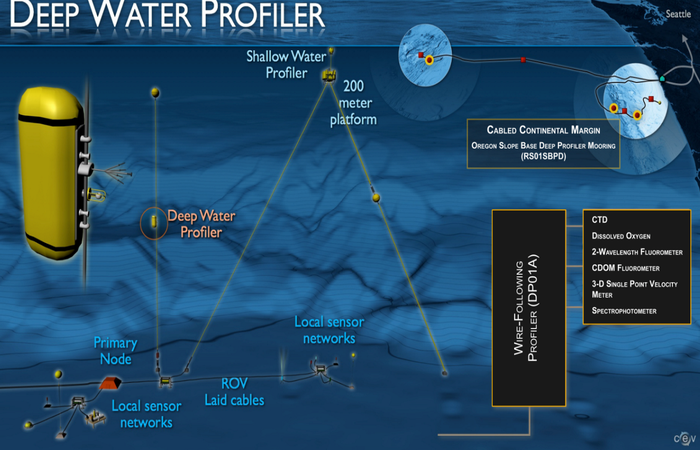

In [7]:
import kilroy
kilroy.ShowImageFromGitHub('oceanhackweek', 'CAHW2018_Materials','Resources','',\
                           'InstallationTypesDiagram.png',700,450)

### Getting Started

* Create a user account on ooinet.oceanobservatories.org: Requires email and password.
* Log in
* Navigate to the drop down menu screen in the top-right corner menu: 'User Profile'
* Notice at the bottom of your user profile your API Username and your API Token. 
  * The API Username is similar to ```OOIAPI-QTULEV9STCAS55``` 
  * The API Token is similar to ```YXP2Q2W4SOP```.
  * Your API Token may identify itself as temporary. If it *does so* hit the **Refresh** button and then save your profile.
* Save these two strings in a file that can not possibly end up in a GitHub repository. 
  * I use the filename '''ooiauth.txt'''
  * Run `chmod 400` so it is readable only by you
  * This file should consist of one line with the Username and Token separated by a comma: 

```
OOIAPI-QTULEV9STCAS55,YXP2Q2W4SOP
```


You can instruct GitHub to ignore the ```ooiauth.txt``` file but this gets away from the spirit of secure authentication.



In [2]:
# Read connection credentials from a file (should be saved in this same directory)
authfile=open('../../../../creds/ooiauth.txt','r')     # format of this file is username,token
line=authfile.readline().rstrip()    # please note rstrip() removes any trailing \n whitespace
authfile.close()
username, token = line.split(',')

In [5]:
# remember not to refer to these directly

### Where are the installations, how are they referenced

There are three shallow profiler + deep profiler locations, called 'Coastal Endurance', 'Slope Base' and 'Axial Base'. 
In what follow considerably more context is given for completeness but this is the gist of what's needed. 


[This page](http://ooi.visualocean.net/regions/view/CE) lists the nine Oregon **Coastal Endurance** installations, of which four are supported on the cabled array. It also lists 'mobile assets' and six moorings off the coast of Washington. Cabled: 


* Oregon Shelf Cabled Benthic Experiment Package (sea floor, depth 79 meters apparently)
* Oregon Offshore Cabled Benthic Experiment Package
* Oregon Offshore Cabled Deep Profiler Mooring
* Oregon OFfshore Cabled Shallow Profiler Mooring


Meanwhile [this page](https://ooinet.oceanobservatories.org/) with the cabled array selected provides a low-resolution 
diagram and a separate listing of assets. We want to enumerate the cabled array assets so let's begin by trying to 
compare these two listings. 

From OOINET we have (distinct from the above)

* Southern Hydrate Summit 1 
* Southern Hydrate Summit 2: These two are very nearly co-located.
* Oregon Slope Base Seafloor
* Oregon Slope Base Shallow Profiler Mooring

...and then eight more installations way out at Axial.


### Relationship between instruments and installations: Two profiler types plus benthics


[The diagram at the top of this page](http://oceanobservatories.org/wp-content/uploads/2015/09/RS01SBPD_OR_Slope_Base_Deep_Profiler.jpg) 
explains the three basic installations schemes: Deep profilers, shallow profilers, and benthic installations. 


- Benthics are on the bottom with nothing moving through the water column. 
- Deep profilers go up and down a wire which is distended vertically off the bottom via a float; well under the surface. 
- Shallow profilers are moored by means of two long cables to a point some way under the surface
  - Shallow profilers use a winch to extend a positively buoyant instrument package up to within 20 meters of so of the surface. 


Let's follow the sequence of websites to where we could fill out the input variables to get to the data.

- [Directory of resources; including CA (code letters RS)](http://ooi.visualocean.net/)
- [Platform list for the cabled array (RS)](http://ooi.visualocean.net/regions/view/RS)
- [Instrument list for a platform (Oregon slope base shallow profiler mooring)](http://ooi.visualocean.net/sites/view/RS01SBPS)
- [Details for a chosen instrument on that platform (nitrate)](http://ooi.visualocean.net/instruments/view/RS01SBPS-SF01A-4A-NUTNRA101)
- [Data products page for the nitrate instrument](http://ooi.visualocean.net/streams/view/nutnr_a_sample)

In this example we will request pressure data from the Cabled Axial Base (RS03AXPS) - Shallow Profiler (SF03A) - CTD (2A-CTDPFA302) sensor.

Reference Designator: RS03AXPS-SF03A-2A-CTDPFA302  
Delivery Method: streamed  
Stream: ctdpf_sbe43_sample  
Parameter: seawater_pressure  

A good resource for finding the information you will need to input below is the Data Team Portal at http://ooi.visualocean.net/. This resource allows you to identify the Reference Designator, Delivery Method, Stream, and Parameter, alongside english descriptions of the instruments and data products.

In [6]:
# specify your inputs
# Reference designator RS01SBPS-SF01A-4A-NUTNRA101
sub_site = 'RS01SBPS'
platform = 'SF01A'
instrument = '4A-NUTNRA101'
delivery_method = 'streamed'                # this taken from the Method column in the table below
stream = 'nutnr_a_sample'                   # this taken from the Data Stream column in the same table
parameter = 'salinity_corrected_nitrate'    # this from clicking on the Data Stream link to the products page

# Friedrich's example
# sub_site = 'RS03AXPS'
# platform = 'SF03A'
# instrument = '2A-CTDPFA302'
# delivery_method = 'streamed'
# stream = 'ctdpf_sbe43_sample'
# parameter = 'seawater_pressure'

In [7]:
import datetime
import time
import requests
import pprint
from concurrent.futures import ThreadPoolExecutor

In [8]:
# setup the base url for the request that will be built using the inputs above.
BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

# we use ThreadPoolExecutor because it has a method .done, which can be polled for 
# completed of the task executed on that thread.
pool = ThreadPoolExecutor(1)

# time stamps are returned in time since 1900, so we subtract 70 years from 
# the time output using the ntp_delta variable
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

In [9]:
# convert timestamps
def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)

# send request on a thread
def get_future_data(url, params, username, token):
    auth = (username, token)
    return pool.submit(requests.get, url, params=params, auth=auth)

# parse response for timestamp and inform user if no new data returned
def extract_keys(data, keys, min_time):
    rdict = {key: [] for key in keys}
    for record in data:
        if record['time'] <= min_time:
            time_r = record['time']
            time_r = ntp_seconds_to_datetime(time_r)
            time_r = time_r.strftime("%Y-%m-%d %H:%M:%S.000Z")
            print('No new data found since ' + str(time_r) + '. Sending new request.')
            continue
        for key in keys:
            rdict[key].append(record[key])
    print('Found %d new data points after filtering' % len(rdict['time']))
    return rdict


The following script is the main script. It will execute 10 requests, but if put into a while loop it can execute data requests indefinitely. See comments for explanations in line. The data response in json format contains all parameters under the input data stream, however, only prints out the values for the input parameter and corresponding timestamp. Note that the maximum points returned for a given time interval is 1000 points. Right now, the script sends a new request every 0.1 seconds, so you should never receive exceed 1000 points.

In [10]:
def requestNow(username, token, sub_site, platform, instrument, delivery_method, stream, parameter):
    
    # create the base url
    request_url = '/'.join((BASE_URL, sub_site, platform, instrument, delivery_method, stream))
    
    # specify parameters which will be used in the get_future_data function. 
    # with each new request being sent, only the beginDT will change. 
    # it will be set to the time stamp of the last data point received. 
    # notice that there is no endDT specified, as a request with a beginDT 
    # and no endDT will return everything  from beginDT until present, 
    # up to 1000 data points.
    params = {
        'beginDT': None,
        'limit': 1000,
        'user': 'realtime',
    }
    
    # start with the last 10 seconds of data from present time
    begin_time = datetime.datetime.utcnow() - datetime.timedelta(seconds=10)
    
    # last_time will be assigned as the time stamp of the last data point 
    # received once the first request is sent
    last_time = 0
    
    for i in range(10): # replace with `while True:` to enter an endless data request loop
        
        # update beginDT for this request
        begin_time_str = begin_time.strftime('%Y-%m-%dT%H:%M:%S.000Z')
        params['beginDT'] = begin_time_str

        # send request in thread
        data_future = get_future_data(request_url, params, username, token)
        
        # poll until complete
        while not data_future.done:
            # while request not complete, yield control to event loop
            time.sleep(0.1)

        # request complete, if not 200, log error and try again
        response = data_future.result()
        if response.status_code != 200:
            print('Error fetching data', response.text)
            time.sleep(0.1)
            continue
        
        # store json response
        data = response.json()
        
        # use extract_keys function to inform users about whether 
        # or not data is being returned. parse data in json response 
        # for input parameter and corresponding timestamp
        data = extract_keys(data, ['time', parameter], min_time=last_time)

        # if no data is returned, try again
        if not data['time']:
            time.sleep(0.1)
            continue

        # set beginDT to time stamp of last data point returned
        last_time = data['time'][-1]
        begin_time = ntp_seconds_to_datetime(last_time)

        # print data points returned
        print("\n")
        pprint.pprint(data)
        print("\n")
        

In [11]:
requestNow(username, token, sub_site, platform, instrument, delivery_method, stream, parameter)

Error fetching data {
  "message": {
    "status": "{\n  \"message\": \"Query returned no results for primary stream\", \n  \"requestUUID\": \"5d43dc64-f499-41bb-9255-0f032bec645e\"\n}\n"
  },
  "status_code": 404
}
Found 1 new data points after filtering


{'salinity_corrected_nitrate': [295.6011503050597], 'time': [3741889847.554851]}


No new data found since 2018-07-29 21:50:47.000Z. Sending new request.
Found 0 new data points after filtering
No new data found since 2018-07-29 21:50:47.000Z. Sending new request.
Found 1 new data points after filtering


{'salinity_corrected_nitrate': [295.62211818672733],
 'time': [3741889848.4986587]}


No new data found since 2018-07-29 21:50:48.000Z. Sending new request.
Found 0 new data points after filtering
No new data found since 2018-07-29 21:50:48.000Z. Sending new request.
Found 0 new data points after filtering
No new data found since 2018-07-29 21:50:48.000Z. Sending new request.
Found 0 new data points after filtering
No new data foun